In [ ]:
import sys
sys.path.append("./..")

import tsdb
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from datetime import datetime
from loguru import logger

from src.settings import projectsettings
from src.data.datatool import DataProcessor
from src.datastreamers import BaseDatastreamer, BaseDataset
from src.train import trainloop
from src.models import AttentionModel
from src.metrics import BinaryAccuracy, Recall, Precision, F1Score, Accuracy

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)


c:\Users\hassg00\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-11 15:17:01,908	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-12-11 15:17:02,284	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


## Data voorbereiden

In [2]:
dataset = 'physionet_2012'
data = tsdb.load(dataset)
config = {}

print(data.keys())

df_a  = pd.DataFrame(data['set-a'])
df_outcomes_a  = pd.DataFrame(data['outcomes-a']).reset_index()
df_static_features  = pd.DataFrame(data['static_features'])

id = "RecordID"
time = "Time"
target = "In-hospital_death"
global_features = list(df_static_features.iloc[:,0])


processor = DataProcessor(
    df=df_a,
    df_label=df_outcomes_a,  
    id_col=id, 
    time_col=time,
    taget_name=target,
    global_features=global_features,
    cols_exclude_z_norm=[id, time],
    max_wanted_len=5000
)


d3tensor, label_tensor = processor.get_data()

print(f"""
      Shape van data-tensor {d3tensor.shape} 
      Aantal cases zijn: {d3tensor.shape[0]}
      Aantal tijdsobservatie per cases zijn: {d3tensor.shape[1]} (NULL wordt gepad)
      De meet waarde over de tijd zijn: tijdsmoment, event, waarde
""")

2024-12-11 15:17:05 [INFO]: You're using dataset physionet_2012, please cite it properly in your work. You can find its reference information at the below link: 
https://github.com/WenjieDu/TSDB/tree/main/dataset_profiles/physionet_2012
2024-12-11 15:17:05 [INFO]: Dataset physionet_2012 has already been downloaded. Processing directly...
2024-12-11 15:17:05 [INFO]: Dataset physionet_2012 has already been cached. Loading from cache directly...
2024-12-11 15:17:06 [INFO]: Loaded successfully!


dict_keys(['set-a', 'set-b', 'set-c', 'outcomes-a', 'outcomes-b', 'outcomes-c', 'static_features'])
max_wanted_len is langer dan de de aantal timestamps in de data,namelijk: 5000. data heeft max van: 631

      Shape van data-tensor torch.Size([3997, 631, 4]) 
      Aantal cases zijn: 3997
      Aantal tijdsobservatie per cases zijn: 631 (NULL wordt gepad)
      De meet waarde over de tijd zijn: tijdsmoment, event, waarde



In [3]:
# melted_3dtensor = melted_3dtensor.float()
# label_tensor = label_tensor.long()
label_tensor = label_tensor.unsqueeze(1).float()

print(d3tensor.size(), label_tensor.size())
print(d3tensor.shape, label_tensor.shape)
print(d3tensor.dtype, label_tensor.dtype)

config["categorical_size"] = d3tensor[:,:,1].long().max() + 1

config["categorical_size"]

torch.Size([3997, 631, 4]) torch.Size([3997, 1])
torch.Size([3997, 631, 4]) torch.Size([3997, 1])
torch.float32 torch.float32


tensor(49)

In [ ]:
config["batchsize"] = 32

# Split the dataset into train, validation, and test sets
train_data, val_data, train_labels, val_labels = train_test_split(
    d3tensor, label_tensor, test_size=0.2, random_state=42
)

# # Put data in streamer:
# test_streamer = BaseDatastreamer(dataset=BaseDataset(test_data, test_labels), batchsize=config["batchsize"])

# # Split the train_data further into training and validation sets
# train_data, val_data, train_labels, val_labels = train_test_split(
#     train_data, train_labels, test_size=0.3, random_state=42
# )

# Put data in streamer:
train_streamer = BaseDatastreamer(dataset=BaseDataset(train_data, train_labels), batchsize=config["batchsize"])
validation_streamer = BaseDatastreamer(dataset=BaseDataset(val_data, val_labels), batchsize=config["batchsize"])

# Verify the split
print(f"Training set size: {train_data.shape[0]}")
print(f"Validation set size: {val_data.shape[0]}")
# print(f"Test set size: {test_data.shape[0]}")

x, y = next(train_streamer.stream())
train_streamer.index = 0

print(x.shape, y.shape)
print(x.dtype, y.dtype)

Training set size: 3197
Validation set size: 800


## Algoritme
We hebben nu melted_3dtensor en label_tensor als input en labels

In [6]:
# Hyperparameters
config["n_feat"] = x.shape[2]
input_dim = config["n_feat"]  # Number of features in the tensor
hidden_dim = 64                       # Hidden layer size
output_dim = 1 #len(torch.unique(label_tensor))  # Number of output classes
config["epochs"] = 3
config["embedding_dim"] = 4
_ , config["n_window"], config["n_feat"] = x.shape
config["train_steps"] = len(train_streamer)
config["num_heads"] = 1
config["dropout"] = 0.05

In [ ]:
# Create the AttentionModel
model = AttentionModel(input_dim, hidden_dim, output_dim)
model(x).shape

logger.add(projectsettings.logger_dir / "01.log")

# train model
trainedmodel, train_losses, val_losses = trainloop(
    epochs=config["epochs"],
    model=model,  # type: ignore
    optimizer=torch.optim.Adam,
    learning_rate=1e-3,
    loss_fn=nn.BCELoss(), # nn.BCEWithLogitsLoss(), # nn.CrossEntropyLoss(), nn.BCELoss()
    metrics=[BinaryAccuracy(), Recall(), Precision(), F1Score()],
    config_dict=config,
    train_dataloader=train_streamer.stream(),
    test_dataloader=validation_streamer.stream(),
    log_dir=projectsettings.logger_dir,
    train_steps=len(train_streamer),
    eval_steps=len(validation_streamer),
    patience = 6 ,
    factor = 0.5,
    return_losses=True,
)

timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
path = projectsettings.model_dir / (timestamp + model.name)
logger.info(f"save model to {path}")
torch.save(trainedmodel, path)

2024-12-11 15:24:49.868 | INFO     | __main__:dir_add_timestamp:187 - Logging to C:\Users\hassg00\Documents\ruwe_data_snel_inzicht\results\log\20241211-1524test_model_attention
100%|██████████| 3/3 [00:54<00:00, 18.15s/it]
2024-12-11 15:25:44.350 | INFO     | __main__:<module>:23 - save model to C:\Users\hassg00\Documents\ruwe_data_snel_inzicht\results\model\20241211-152544test_model_attention


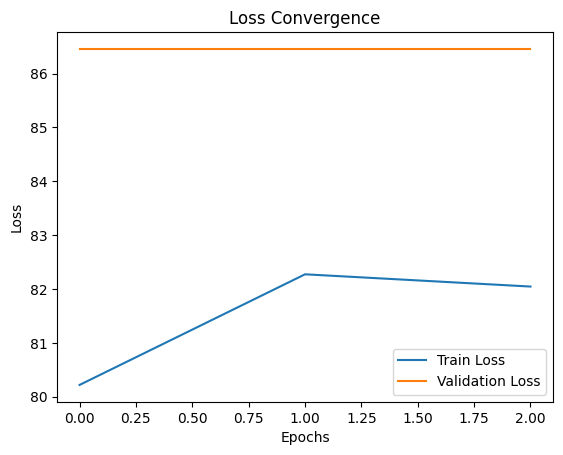

In [18]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Convergence")
plt.show()
